<a href="https://colab.research.google.com/github/AJAkil/All-things-AI/blob/master/DeepCourse_VIT_Practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pickle
import math

import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
import torchvision.utils as vutils
import torchvision
from PIL import Image

In [3]:
transform = transforms.Compose([
  transforms.ToTensor()
])

train_dataset = torchvision.datasets.MNIST('.', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST('.', train=False, download=True, transform=transform)


train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [4]:
real_batch = next(iter(train_loader))
real_batch[1].shape

torch.Size([128])

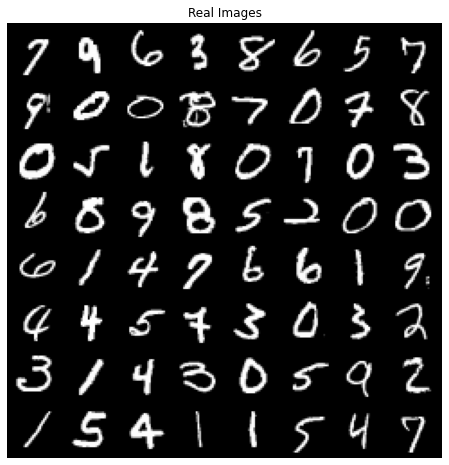

In [5]:
real_batch = next(iter(train_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Real Images")
plt.imshow(vutils.make_grid(real_batch[0][:64], normalize=True).permute(1,2,0))
plt.show()

In [6]:
class PatchEmbed(nn.Module):
  def __init__(self, in_chan=1, patch_size=7, embed_dim=128):
    super().__init__()
    self.projection = nn.Conv2d(in_chan, embed_dim, kernel_size=patch_size, stride=patch_size)

  def forward(self, x):
    x = self.projection(x)

    B, C, H, W = x.shape

    # reshaping to (batch_size, nb_tokens, embedding_dim)
    x = x.permute(0,2,3,1).reshape([B, H*W, C])

    return x

In [7]:
PatchEmbed()(torch.randn(32, 1, 28, 28)).shape

torch.Size([32, 16, 128])

In [8]:
# Execute this cell to see the solution, but try to do it by yourself before!
!wget https://raw.githubusercontent.com/arthurdouillard/deepcourse/master/static/code/transf/patch.py
%pycat patch.py

--2023-03-12 17:27:10--  https://raw.githubusercontent.com/arthurdouillard/deepcourse/master/static/code/transf/patch.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 521 [text/plain]
Saving to: ‘patch.py’

patch.py            100%[===================>]     521  --.-KB/s    in 0s      

2023-03-12 17:27:10 (29.5 MB/s) - ‘patch.py’ saved [521/521]



In [27]:
class MLP(nn.Module):
  def __init__(self, in_features, hid_features):
    super().__init__()
    self.linear = nn.Linear(in_features, hid_features)
    self.GELU = nn.GELU()
    self.linear_2 = nn.Linear(hid_features, in_features)

  def forward(self, x):
    x = self.linear_2(self.GELU(self.linear(x)))
    return x



In [10]:
MLP(128, 512)(torch.randn(32, 16, 128)).shape

torch.Size([32, 16, 128])

In [11]:
# Execute this cell to see the solution, but try to do it by yourself before!
!wget https://raw.githubusercontent.com/arthurdouillard/deepcourse/master/static/code/transf/mlp.py
%pycat mlp.py

--2023-03-12 17:27:10--  https://raw.githubusercontent.com/arthurdouillard/deepcourse/master/static/code/transf/mlp.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 309 [text/plain]
Saving to: ‘mlp.py’

mlp.py              100%[===================>]     309  --.-KB/s    in 0s      

2023-03-12 17:27:10 (16.7 MB/s) - ‘mlp.py’ saved [309/309]



In [28]:
class SelfAttention(nn.Module):
  def __init__(self, embed_dim):
    super().__init__()
    self.query_transform = nn.Linear(embed_dim, embed_dim, bias=False)
    self.key_transform   = nn.Linear(embed_dim, embed_dim, bias=False)
    self.value_transform = nn.Linear(embed_dim, embed_dim, bias=False)
    self.scale = embed_dim**-0.5
    self.linear = nn.Linear(embed_dim, embed_dim)
  
  def forward(self, x):
    B, N, C = x.shape

    q = self.query_transform(x)
    k = self.key_transform(x)
    v = self.value_transform(x)
    #print(v.shape)

    attention = torch.matmul(q, k.transpose(1,2)) * self.scale
    #print(attention.shape)
    attention = torch.softmax(attention, dim = -1)
    x = torch.matmul(attention, v)
    return self.linear(x)


In [13]:
SelfAttention(128)(torch.randn(32, 16, 128)).shape

torch.Size([32, 16, 128])
torch.Size([32, 16, 16])


torch.Size([32, 16, 128])

In [14]:
x = torch.randn(3,3)
print(x)
print(x.shape)

torch.softmax(x, dim = -1)

tensor([[ 0.1710, -0.0284,  0.7758],
        [-0.3946, -0.1757,  1.7481],
        [-0.1024, -0.2392, -0.2992]])
torch.Size([3, 3])


tensor([[0.2740, 0.2244, 0.5016],
        [0.0929, 0.1156, 0.7915],
        [0.3713, 0.3238, 0.3049]])

In [15]:
# Execute this cell to see the solution, but try to do it by yourself before!
!wget https://raw.githubusercontent.com/arthurdouillard/deepcourse/master/static/code/transf/sa.py
%pycat sa.py

--2023-03-12 17:27:10--  https://raw.githubusercontent.com/arthurdouillard/deepcourse/master/static/code/transf/sa.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 642 [text/plain]
Saving to: ‘sa.py’

sa.py               100%[===================>]     642  --.-KB/s    in 0s      

2023-03-12 17:27:10 (52.7 MB/s) - ‘sa.py’ saved [642/642]



In [29]:
class Block(nn.Module):
  def __init__(self, embed_dim, mlp_ratio=4):
    super().__init__()
    self.layer_norm_1 = nn.LayerNorm(embed_dim)
    self.layer_norm_2 = nn.LayerNorm(embed_dim)

    self.mlp = MLP(embed_dim, embed_dim * mlp_ratio)
    self.self_attention = SelfAttention(embed_dim)
  
  def forward(self, x):
    x = x + self.self_attention(self.layer_norm_1(x))
    # print(x.shape)
    x = x + self.mlp(self.layer_norm_2(x))
    return x

    return x

In [30]:
class Block(nn.Module):
  def __init__(self, embed_dim, mlp_ratio=4):
    super().__init__()

    self.attention = SelfAttention(embed_dim)
    self.norm1 = nn.LayerNorm(embed_dim)
    self.mlp = MLP(embed_dim, embed_dim * mlp_ratio)
    self.norm2 = nn.LayerNorm(embed_dim)

  def forward(self, x):
    x = x + self.attention(self.norm1(x))
    x = x + self.mlp(self.norm2(x))
    return x

In [18]:
Block(128)(torch.randn(32, 16, 128)).shape

torch.Size([32, 16, 128])
torch.Size([32, 16, 16])


torch.Size([32, 16, 128])

In [19]:
# Execute this cell to see the solution, but try to do it by yourself before!
!wget https://raw.githubusercontent.com/arthurdouillard/deepcourse/master/static/code/transf/block.py
%pycat block.py

--2023-03-12 17:27:11--  https://raw.githubusercontent.com/arthurdouillard/deepcourse/master/static/code/transf/block.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 391 [text/plain]
Saving to: ‘block.py’

block.py            100%[===================>]     391  --.-KB/s    in 0s      

2023-03-12 17:27:11 (27.8 MB/s) - ‘block.py’ saved [391/391]



In [31]:
class ViT(nn.Module):
  def __init__(self, embed_dim, nb_transformer_blocks, patch_size, nb_classes=10):
    super().__init__()

    num_patches = (28 // patch_size) ** 2

    self.class_token = nn.Parameter(torch.randn(1, 1, embed_dim))
    self.pos_embed = nn.Parameter(torch.randn(1, num_patches + 1, embed_dim))
    self.patch_embed = PatchEmbed(patch_size=patch_size, embed_dim=embed_dim)

    blocks = [Block(embed_dim) for _ in range(nb_transformer_blocks)]

    self.blocks = nn.Sequential(*blocks)
    self.norm = nn.LayerNorm(embed_dim)
    self.head = nn.Linear(embed_dim, nb_classes)

  def forward(self, x):
    
    #print(x.shape)
    x = self.patch_embed(x)
    #print(x.shape)

    class_token = self.class_token.expand(x.shape[0], -1, -1)
    #print('class token shape:', class_token.shape)

    x = torch.cat((class_token, x), dim=1)
    #print('x shape after concatenating with class token: ', x.shape)
    #print('pos embeddings shape: ', self.pos_embed.shape)
    x = x + self.pos_embed # broadcasting (1, 17, 128) to (batch_size, 16, 128)
    #print('x shape after concatenating with positional embedding: ', x.shape)
    x = self.blocks(x)
    x = self.norm(x)

    return self.head(x[:, 0]) # taking all batch and the class token(first embedding) from them



In [21]:
ViT(128, 3, 7)(torch.randn(32, 1, 28, 28)).shape

torch.Size([32, 17, 128])
torch.Size([32, 17, 17])
torch.Size([32, 17, 128])
torch.Size([32, 17, 17])
torch.Size([32, 17, 128])
torch.Size([32, 17, 17])


torch.Size([32, 10])

In [25]:
@torch.no_grad()
def eval_model(model, loader):
  model.eval()
  acc = 0.
  c = 0

  for x, y in loader:
    x, y = x.cuda(), y.cuda()
    yhat = model(x)

    acc += torch.sum(yhat.argmax(dim=1) == y).cpu().item()
    c += len(x)

  model.train()
  return round(100 * acc / c, 2)

In [32]:
epochs = 10

embed_dim = 32
patch_size = 7
nb_blocks = 2

model = ViT(embed_dim, nb_blocks, patch_size).cuda()

opt = torch.optim.Adam(model.parameters())

for epoch in range(epochs):
  train_loss = 0.
  for x, y in train_loader:
    x, y = x.cuda(), y.cuda()

    opt.zero_grad()
    yhat = model(x)
    loss = F.cross_entropy(yhat, y)
    loss.backward()

    opt.step()

    train_loss += loss.item()

  print(f"--- Epoch {epoch} ---")
  print(f"Train loss: {train_loss / len(train_loader)}")
acc = eval_model(model, test_loader)
print(f"Test accuracy: {acc}")
  

--- Epoch 0 ---
Train loss: 0.8216630220413208
--- Epoch 1 ---
Train loss: 0.2735871227978389
--- Epoch 2 ---
Train loss: 0.20257049737009666
--- Epoch 3 ---
Train loss: 0.16572319043438827
--- Epoch 4 ---
Train loss: 0.14504306997730534
--- Epoch 5 ---
Train loss: 0.12559870976422513
--- Epoch 6 ---
Train loss: 0.11495266786849956
--- Epoch 7 ---
Train loss: 0.1027607403949761
--- Epoch 8 ---
Train loss: 0.09682309263741284
--- Epoch 9 ---
Train loss: 0.08963767874604667
Test accuracy: 97.11


In [48]:
class MultiHeadsSelfAttention(nn.Module):
  def __init__(self, embed_dim, num_heads):
    super().__init__()

    head_dim = embed_dim // num_heads
    self.scale = head_dim ** -0.5
    self.num_heads = num_heads

    self.q = nn.Linear(embed_dim, embed_dim, bias=False)
    self.k = nn.Linear(embed_dim, embed_dim, bias=False)
    self.v = nn.Linear(embed_dim, embed_dim, bias=False)
    self.projection = nn.Linear(embed_dim, embed_dim)

  def forward(self, x):
    B, N, C = x.shape
    print(B, N, C)
  
    q = self.q(x)
    k = self.k(x)
    v = self.v(x)
    print(q.shape)

    q = q.reshape(B, N, C // self.num_heads, self.num_heads)
    k = k.reshape(B, N, C // self.num_heads, self.num_heads)
    v = v.reshape(B, N, C // self.num_heads, self.num_heads)
    
    x = q.permute(0, 2, 1, 3)
    x = k.permute(0, 2, 1, 3)
    x = v.permute(0, 2, 1, 3)

    attention = torch.matmul(q, k.transpose(2,3)) * self.scale
    #print(attention.shape)
    attention = torch.softmax(attention, dim = -1)
    x = torch.matmul(attention, v)

    x = x.permute(0, 2, 1, 3)
    x = x.reshape(B, N, C)
    x = self.projection(x)
    return x


MultiHeadsSelfAttention(6, 2)(torch.randn(32, 16, 6)).shape

32 16 6
torch.Size([32, 16, 6])


torch.Size([32, 16, 6])

In [47]:
# Execute this cell to see the solution, but try to do it by yourself before!
!wget https://raw.githubusercontent.com/arthurdouillard/deepcourse/master/static/code/transf/mhsa.py
%pycat mhsa.py

--2023-03-12 17:51:30--  https://raw.githubusercontent.com/arthurdouillard/deepcourse/master/static/code/transf/mhsa.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1079 (1.1K) [text/plain]
Saving to: ‘mhsa.py.9’

mhsa.py.9           100%[===================>]   1.05K  --.-KB/s    in 0s      

2023-03-12 17:51:30 (72.6 MB/s) - ‘mhsa.py.9’ saved [1079/1079]

